In [1]:
from pathlib import Path
import tensorflow as tf
import numpy as np
import pandas as pd

# from config import DATA_ROOT
# from utils import import_key_data
# from ecg_predict import batched_predict_all
from explainer import run_fused_pipeline_for_classes

%load_ext autoreload
%autoreload 2

In [2]:
# gender, age, labels, ecg_filenames = import_key_data(DATA_ROOT)

In [3]:
ROOT = Path.cwd().parent

MODEL_PATH         = ROOT / "model" / "resnet_final.keras"
SNOMED_CLASSES_NPY = ROOT / "data" / "snomed_classes.npy"
SEL_DF_CSV         = ROOT / "data" / "ecg_model_pred_data.csv"

model = tf.keras.models.load_model(MODEL_PATH, compile=False)
class_names = np.load(SNOMED_CLASSES_NPY, allow_pickle=True)

In [4]:
# probs = batched_predict_all(
#     model,
#     ecg_filenames,
#     maxlen=5000,
#     batch_size=32,
# )

# np.save("ecg_model_probs.npy", probs)
# np.save("ecg_filenames.npy", ecg_filenames)

In [ ]:
from config_targets import TARGET_META
from selection import build_selection_df_with_aliases

ecg_filenames = np.load("ecg_filenames.npy", allow_pickle=True)
probs         = np.load("ecg_model_probs.npy")
class_names   = np.load("snomed_classes.npy", allow_pickle=True)

sel_df = build_selection_df_with_aliases(
    ecg_filenames=ecg_filenames,
    probs=probs,
    class_names=class_names,
    target_meta=TARGET_META,
    y_true=None,          # or y_true if you have it
    k_per_class=5,
    min_prob=0.85,
    max_duration_sec=20.0,
    duration_cache_path="ecg_durations.npy",
)

sel_df.to_csv("ecg_xai_sel_meta_p0.85_k5.csv", index=False)
sel_df


[INFO] Estimating durations and keeping ECGs <= 20.0 s...


Target classes: ['426783006']


<Figure size 2000x600 with 0 Axes>

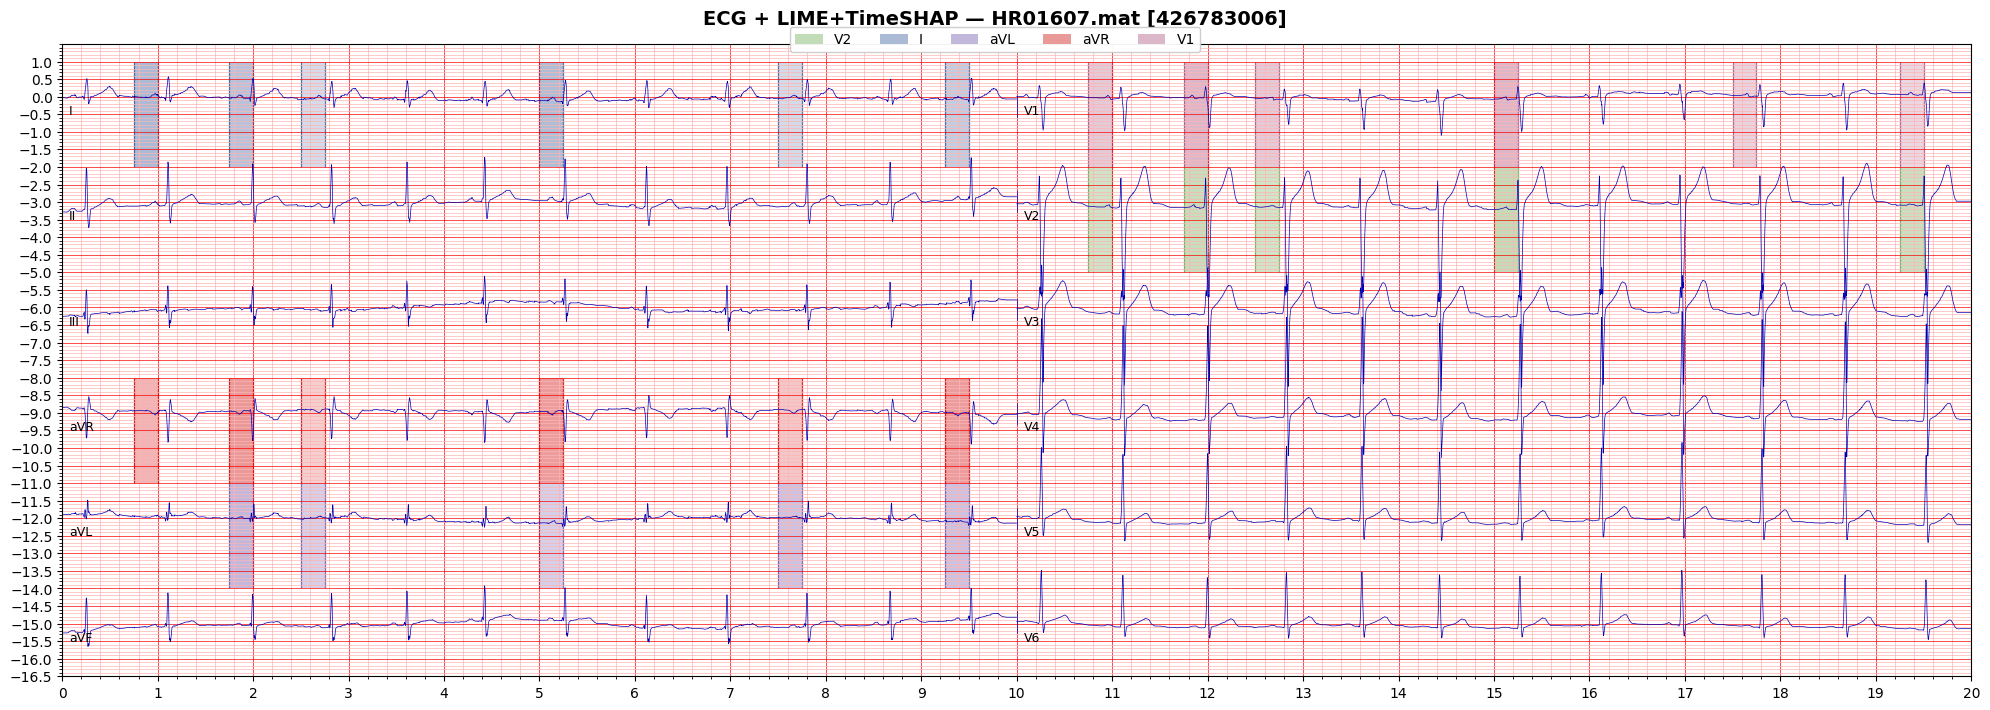

<Figure size 2000x600 with 0 Axes>

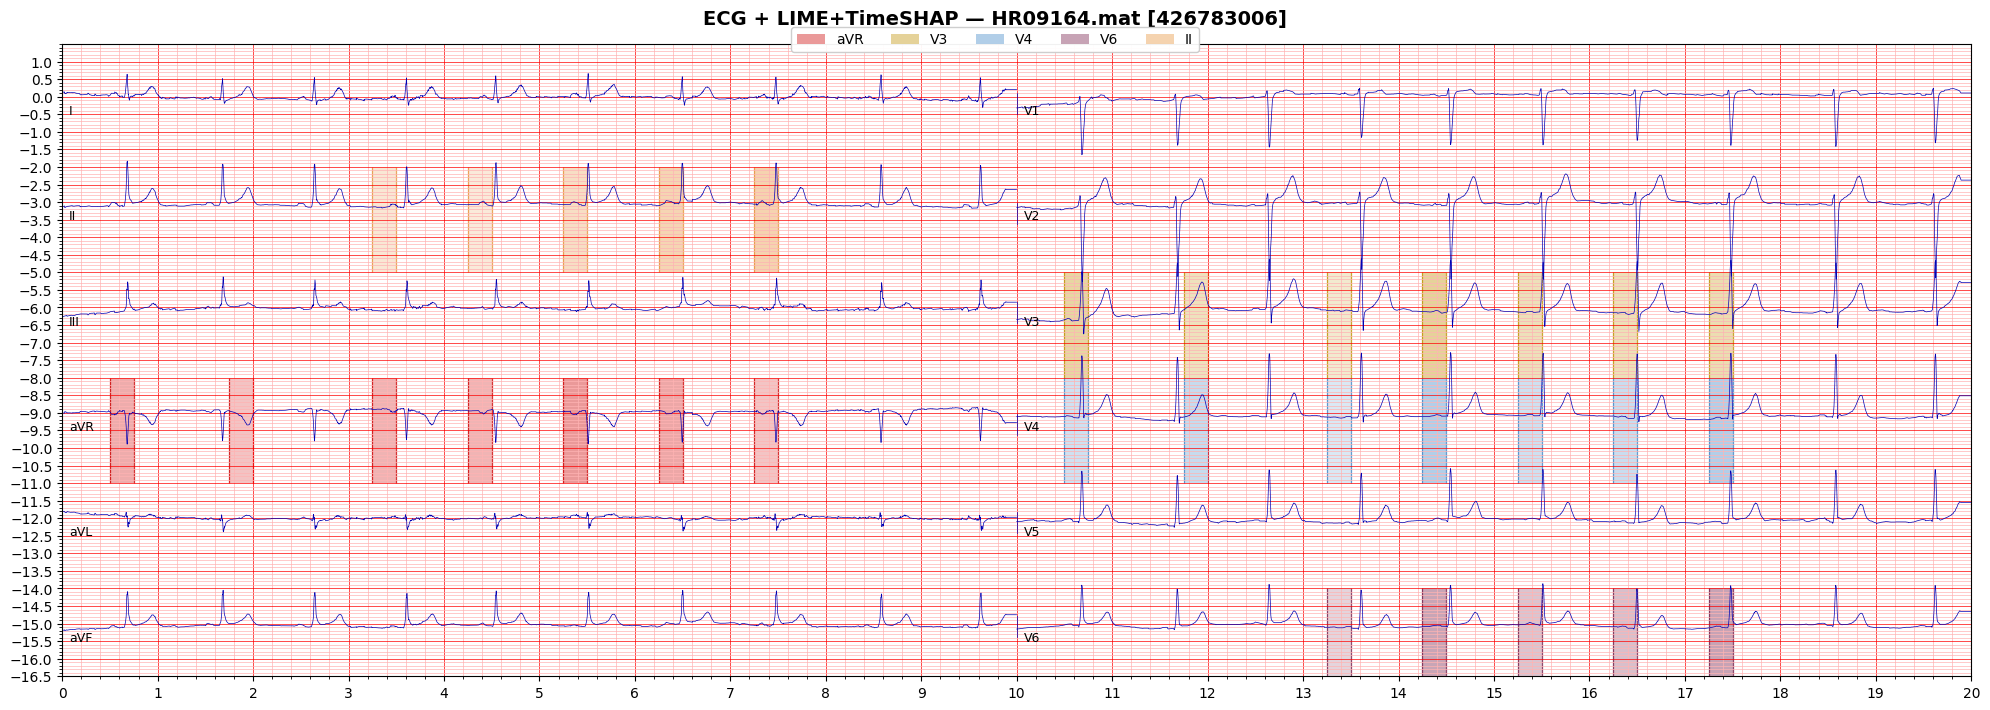

<Figure size 2000x600 with 0 Axes>

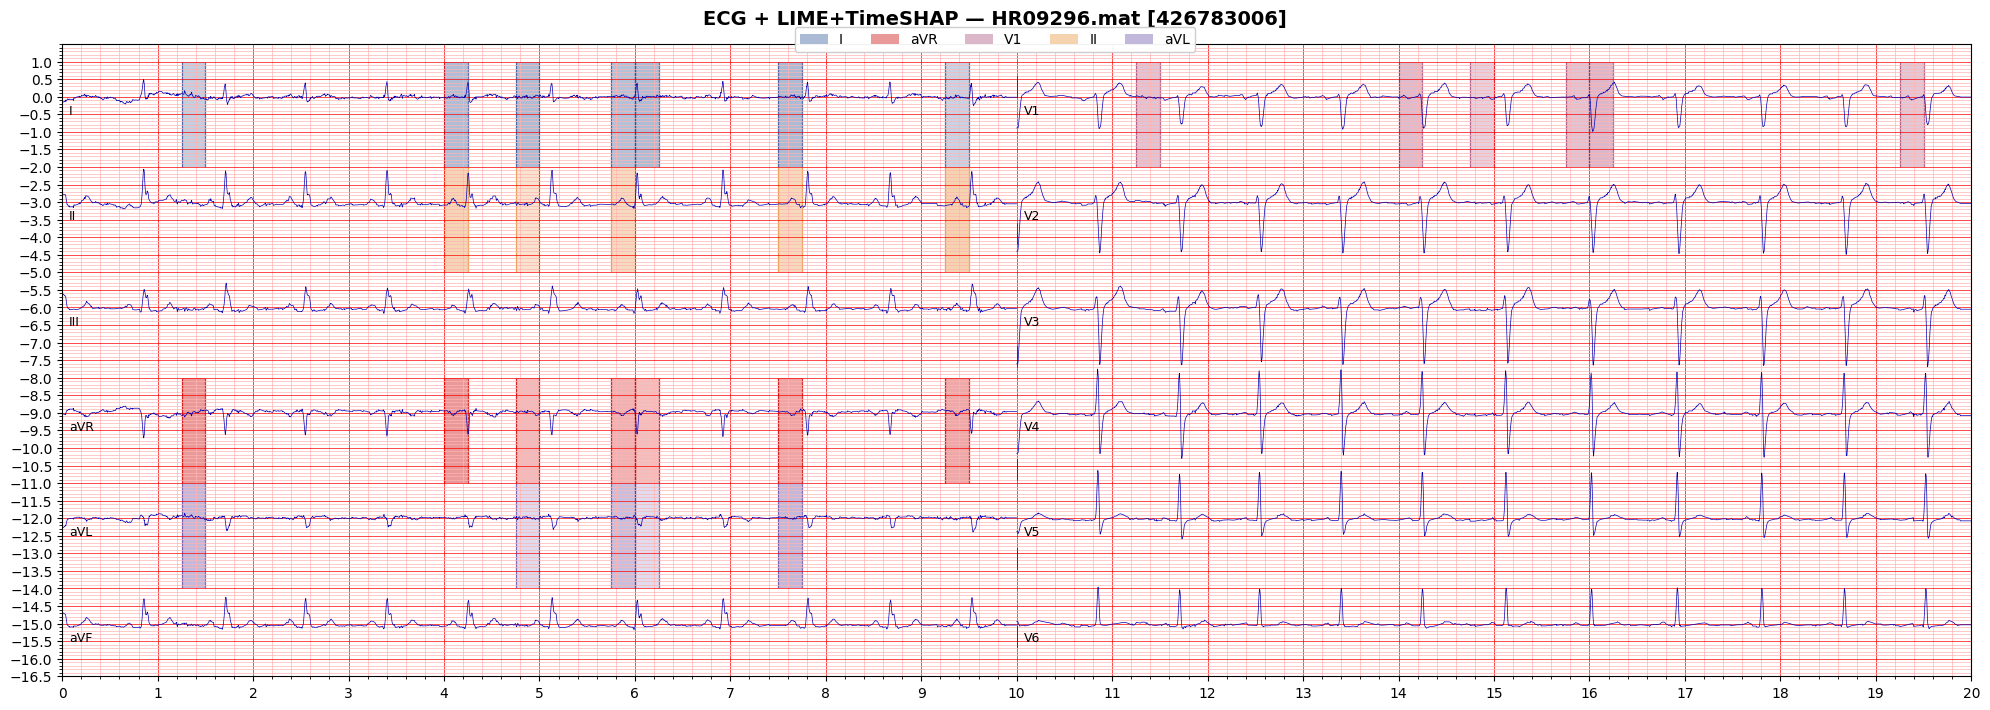

<Figure size 2000x600 with 0 Axes>

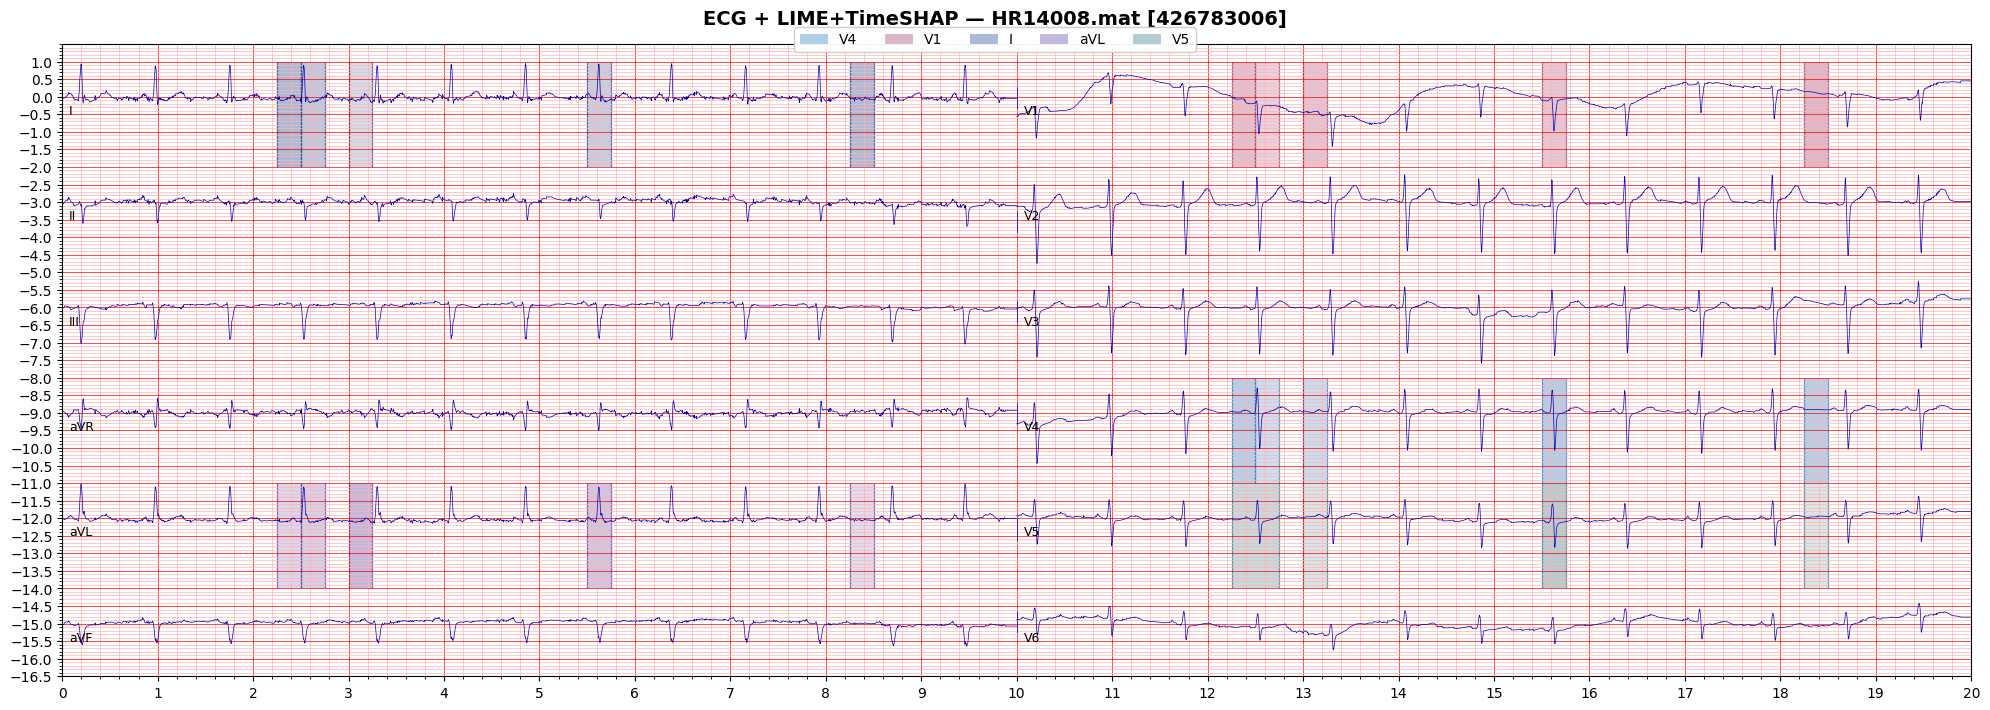

<Figure size 2000x600 with 0 Axes>

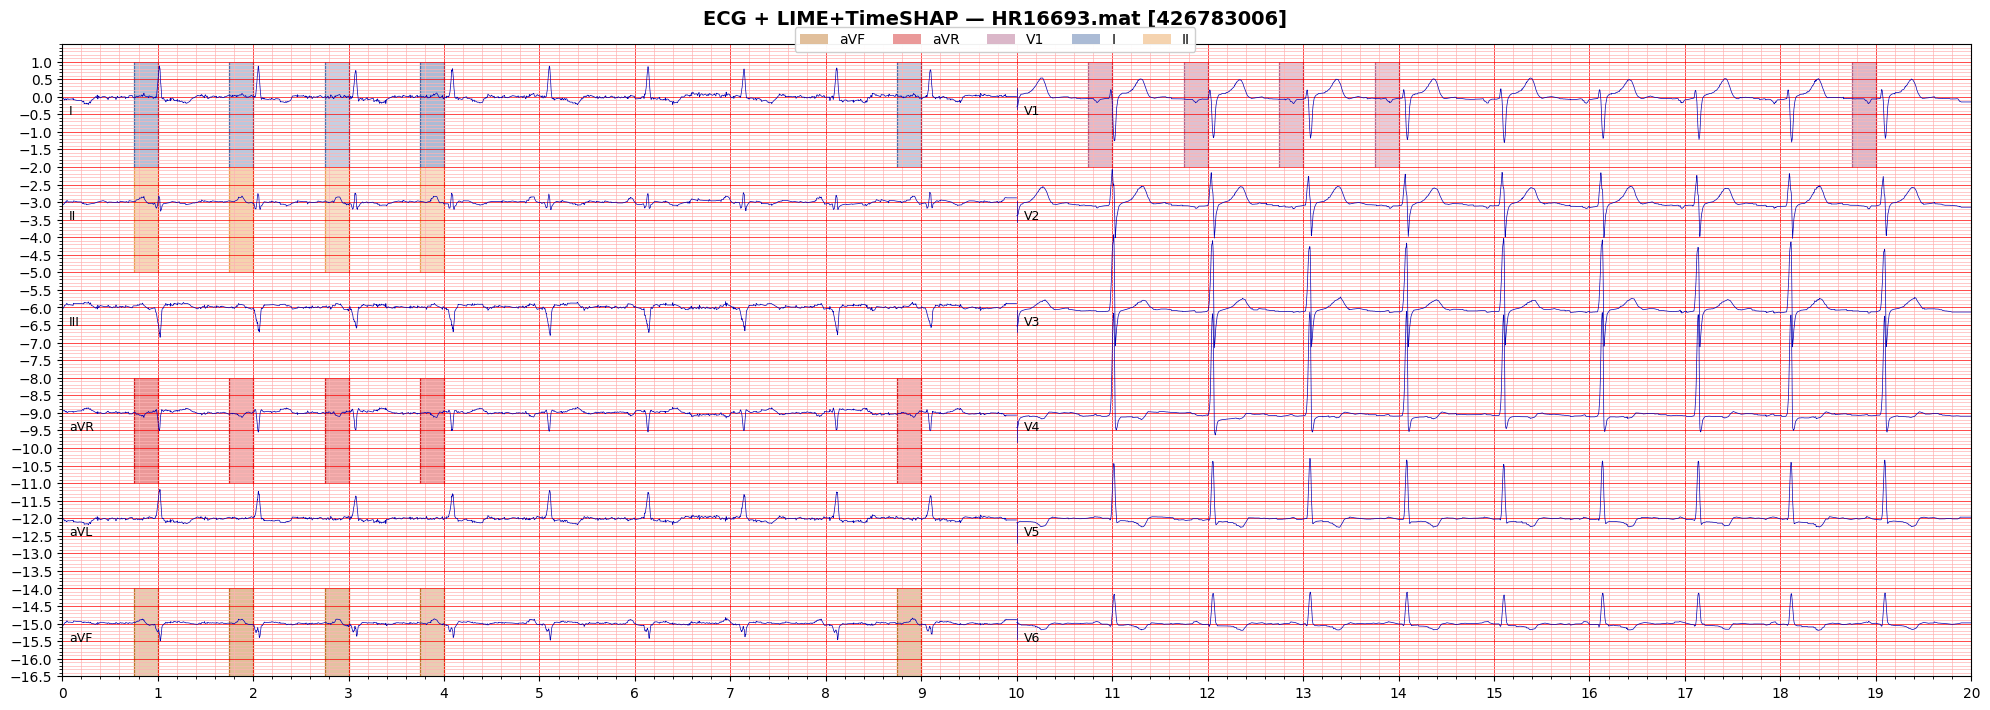

In [ ]:
target_classes = list(TARGET_META.keys())   # ["164889003", "426783006", "17338001"]

print("Target classes:", target_classes)

all_fused_payloads, df_lime_all, df_ts_all = run_fused_pipeline_for_classes(
    target_classes=target_classes,
    sel_df=sel_df,
    model=model,
    class_names=class_names,
    max_examples_per_class=5,
    plot=True,
)


In [ ]:
from pathlib import Path
from typing import Dict

from eval import evaluate_explanation, LEADS12
from preprocessing import infer_fs_from_header

def evaluate_all_payloads(
    all_payloads: Dict[str, Dict[int, dict]],
    *,
    method_label: str | None = None,
    debug: bool = False,
) -> pd.DataFrame:
    """
    all_payloads: {meta_code -> {sel_idx -> payload}}
                  meta_code is e.g. '164889003' (AF), '426783006' (SNR), '17338001' (VPB)

    Returns a DataFrame with one row per (ECG, class, method).
    """
    rows = []

    for meta_code, cases in all_payloads.items():
        # Map SNOMED meta-code → human-readable name defined in REGISTRY
        class_name = TARGET_META[meta_code]["name"]  # e.g. "atrial fibrillation"

        for sel_idx, payload in cases.items():
            mat_path = Path(payload["mat_path"])
            hea_path = mat_path.with_suffix(".hea")

            # Sampling freq from header
            fs = infer_fs_from_header(hea_path)  # returns float or int

            # Run AttAUC (+ optional deletion curve if you later pass model_predict_proba)
            result = evaluate_explanation(
                mat_path=str(mat_path),
                fs=float(fs),
                payload=payload,
                class_name=class_name,
                rpeaks_sec=None,          # let it detect its own R-peaks
                lead_names=LEADS12,       # ("I","II",...,"V6")
                model_predict_proba=None, # AttAUC only for now
                debug=debug,
            )

            rows.append({
                "meta_code": meta_code,
                "class_name": class_name,
                "sel_idx": sel_idx,
                "mat_path": str(mat_path),
                "method": method_label or payload.get("method_label", "unknown"),

                "strict_attauc": result.strict_attauc,
                "lenient_attauc": result.lenient_attauc,
                "n_tokens": result.n_tokens,
            })

    df = pd.DataFrame(rows)
    return df

In [ ]:
df_eval_all = evaluate_all_payloads(
    all_fused_payloads,
    method_label="LIME+TimeSHAP",
    debug=True
)

df_eval_all


,meta_code,class_name,sel_idx,mat_path,method,strict_attauc,lenient_attauc,n_tokens
0,426783006,sinus rhythm,22796,C:\data\ptbxl-electrocardiography-database\WFD...,LIME+TimeSHAP,0.646528,0.625298,144
1,426783006,sinus rhythm,30353,C:\data\ptbxl-electrocardiography-database\WFD...,LIME+TimeSHAP,0.590500,0.458000,120
2,426783006,sinus rhythm,30485,C:\data\ptbxl-electrocardiography-database\WFD...,LIME+TimeSHAP,0.622934,0.658560,132
3,426783006,sinus rhythm,35197,C:\data\ptbxl-electrocardiography-database\WFD...,LIME+TimeSHAP,0.579882,0.505579,156
4,426783006,sinus rhythm,37882,C:\data\ptbxl-electrocardiography-database\WFD...,LIME+TimeSHAP,0.642593,0.637390,108


In [ ]:
from eval import evaluate_explanation

meta_code = "426783006"
row = df_eval_all.iloc[0] # pick one row
sel_idx = int(row["sel_idx"])
payload = all_fused_payloads[meta_code][sel_idx]

out = evaluate_explanation(
    mat_path=payload["mat_path"],
    fs=payload.get("fs", 500.0),
    payload=payload,
    class_name=row["class_name"],
    debug=True,
)

print("Strict pos/neg:", out.debug.n_pos_strict, out.debug.n_neg_strict)
print("Lenient pos/neg:", out.debug.n_pos_lenient, out.debug.n_neg_lenient)
print("Top tokens:")
for t in out.debug.top_tokens:
    print(
        f"{t.idx:3d}  {t.lead:3s}  {t.window_type:7s}  "
        f"{t.t_start:5.2f}-{t.t_end:5.2f}  "
        f"score={t.score:7.4f}  "
        f"strict={t.strict_label}  lenient={t.lenient_label}"
    )

Strict pos/neg: 24 120
Lenient pos/neg: 60 84
Top tokens:
 50  aVL  pre       1.76- 1.93  score= 1.0000  strict=0  lenient=0
 90  V2   pre       5.03- 5.20  score= 1.0000  strict=0  lenient=1
 14  II   pre       1.76- 1.93  score= 1.0000  strict=1  lenient=1
  6  I    pre       5.03- 5.20  score= 0.9053  strict=0  lenient=1
 86  V2   pre       1.76- 1.93  score= 0.8814  strict=0  lenient=1
 38  aVR  pre       1.76- 1.93  score= 0.8536  strict=0  lenient=0
 74  V1   pre       1.76- 1.93  score= 0.8432  strict=1  lenient=1
 78  V1   pre       5.03- 5.20  score= 0.8409  strict=1  lenient=1
 47  aVR  pre       9.29- 9.46  score= 0.8080  strict=0  lenient=0
 42  aVR  pre       5.03- 5.20  score= 0.8075  strict=0  lenient=0
